# Particle_sorter_worked_example

#### This notebook file gives details of the Particle_sorter function that does the initial data processing

NB: This notebook runs the Particle_sorter function for one inputted .csv file to demonstrate how it works. To combine data from multiple nested images the Particle_sorter function is run multiple times in a loop - see notebook Particle_size_analysis.ipynb for details.

This notebook contains the code in full, including the functions within it (bin_creator, size_filter and normalise_data) that can be found in Particle_functions_area_fixed.py

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import DataFrame
import matplotlib.pyplot as plt
import math
from textwrap import wrap

from Particle_functions import bin_creator
from Particle_functions import size_filter
from Particle_functions import normalise_data
from Particle_errors import MinBinTooBig

# 1. Inputting particle size data

Import the file outputted from ImageJ/Fiji (only for demo purposes so this notebook can produce outputs - see notebook Particle_size_analysis.ipynb to see how to input data for multiple images).

In [2]:
file_path = 'Results.csv'

# insert file name in the format 
# pd.read_csv(r'Path to your file name here\File name'.csv)
size_data = pd.read_csv(file_path)

# Displays only first 5 rows of dataframe size_data
size_data.head(5)

,,Area,Major,Minor,Angle,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity
0,1,0.812,1.484,0.697,60.215,0.743,1.508,291,260,60.124,0.733,2.129,0.470,0.953
1,2,0.853,1.059,1.026,166.796,0.911,1.091,485,212,109.359,1.034,1.033,0.968,0.961
2,3,1.715,1.763,1.238,142.296,0.850,1.762,557,228,158.703,1.251,1.424,0.702,0.959
3,4,0.527,0.986,0.680,105.799,0.853,1.039,865,212,110.376,0.696,1.448,0.690,0.960
4,5,1.355,1.644,1.050,127.455,0.851,1.648,1038,214,127.451,1.043,1.566,0.639,0.967


Give the image area and scale of image to allow data to be filtered (for demo purposes only - normally inputted as part of file_list.txt. See Particle_size_analysis.ipynb).

In [3]:
im_area = 3600 # um^2   Give area of image here
pix_per_um = 36 # scale of the image in pixels per micron

# Give minimum pixel diameter of particles to consider
min_size_threshold = 10 

&nbsp;   
&nbsp;   
***
# 2. Filtering particle size data

Particles that are too big to be properly represented or too small to be seen need to be filtered from the data. Particles > 1% of the image area or < 10 pixels across are discarded.

This is the code for the size_filter function found in Particle_functions_area.py

In [4]:
# Changing minimum particle diameter above from 
# pixels into microns
min_area = (min_size_threshold /(2*pix_per_um))**2 * math.pi 

max_area = round(im_area / 100 , 1) # An area > 1% of the total image area

print("Particles smaller than", round(min_area,1), \
      "um^2 in area will be discarded.") 
print("Particles larger than", max_area, \
      " um^2 will also be discarded.")

Particles smaller than 0.1 um^2 in area will be discarded.
Particles larger than 36.0  um^2 will also be discarded.


The equivalent diameters of each particles are calculated from the area data.

In [5]:
# Calculates the equivalent diameter from the area of each particle
Eq_di = (size_data["Area"] / math.pi) ** (1/2) *2 

# Copies dataframe size_data to allow 
# calculated equivalent diameter data to be added
size_data=size_data.copy() 

# places equivalent diameter (Eq Di) column into dataframe
size_data["Eq Di"] = Eq_di 

size_data.head(5) # Displays first 5 rows of dataframe size_data

,,Area,Major,Minor,Angle,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Eq Di
0,1,0.812,1.484,0.697,60.215,0.743,1.508,291,260,60.124,0.733,2.129,0.470,0.953,1.016794
1,2,0.853,1.059,1.026,166.796,0.911,1.091,485,212,109.359,1.034,1.033,0.968,0.961,1.042148
2,3,1.715,1.763,1.238,142.296,0.850,1.762,557,228,158.703,1.251,1.424,0.702,0.959,1.477703
3,4,0.527,0.986,0.680,105.799,0.853,1.039,865,212,110.376,0.696,1.448,0.690,0.960,0.819144
4,5,1.355,1.644,1.050,127.455,0.851,1.648,1038,214,127.451,1.043,1.566,0.639,0.967,1.313484


The calculated size thresholds are then used to filter out any data that is too large or too small and the area of measured particles is calculated.

The area of measured particles is considered to be the total area of particles excluding those that have been filtered from the data for being too large. Particles filtered out for being too small are considered to still be in the pore space between the other particles and so are not removed from the total area measured.

In [6]:
# Finds the total area of all measured particles 
# before filtering takes place
total_area = round(sum(size_data["Area"]), 1)
print("A total particle area of", total_area, "um^2 has been \
measured in the image")


A total particle area of 124.8 um^2 has been measured in the image


In [7]:
# Filters out any values that are too big
data_not_bigs = size_data[ size_data["Area"] < max_area ] 

# Calculates the number of particles that are filtered 
# out for being too big
too_big = len(size_data) - len(data_not_bigs)

# Calculates the total area of all remaining particles 
# now particles too large have been removed
total_area_not_bigs = round(sum(data_not_bigs["Area"]),1) 

# Calculates the area of particles >1% image area that are excluded
area_too_big = total_area - total_area_not_bigs 

In [8]:
# Filters out any values that are too small
filtered_data = data_not_bigs[ data_not_bigs["Area"] > min_area] 

# Calculates the number of particles that are filtered 
# out for being too small
too_small = len(data_not_bigs) - len(filtered_data) 


In [9]:
# Calculates the total number of removed particles
no_removed = too_small + too_big 
particles_remaining = len(size_data) - no_removed

print(f"Filtering has removed {no_removed} particles from the data.")
print(f"{too_small} particles were smaller than 10 pixels across.")
print(f"{too_big} particles were larger than 1% of the image area")
print("The remaining area of particles once those too large are \
removed is", total_area_not_bigs, "um^2")
print("There are", particles_remaining, "particles remaining")

Filtering has removed 1 particles from the data.
1 particles were smaller than 10 pixels across.
0 particles were larger than 1% of the image area
The remaining area of particles once those too large are removed is 124.8 um^2
There are 84 particles remaining


&nbsp;   
&nbsp;  
***
# 3. Sort data in equivalent diameter bins

The data are sorted into geometric bins, each $10^{0.1}$ larger than the previous bin. Geometric bins are chosen so that the stereological conversion is simpler (Sahagrian & Proussevitch, 1998).  
The first (smallest) bin is taken to be the minimum size threshold, beneath which any data has been filtered out.

This is the code for bin_creator found in Particle_functions_area.py

In [10]:
bins = np.zeros(46) # Creates empty array of bins to iterate over below
# 10^(bin_multiplier) gives the size of the next bin 
# (See Sahagrian & Proussevitch, 1998)
bin_multiplier = 0.1 


# The first bin value is the minimum diameter 
# (10 / scale of the image, as calculated above)
bins[0] = min_area 
# The 2nd bin is 10^(bin_multiplier) larger than the first bin
bins[1] = bins[0] * (10**bin_multiplier) 

for index, value in enumerate(bins): # Creates geometric bins
    if index < len(bins)-1:
        bins[index+1] = value * 10**bin_multiplier  

In [11]:
# Bin edges are sorted into lower and upper bounds
# to display each bin clearly
bins_lower = bins[:-1] 
bins_upper = bins[1:]

# Bin edges are placed in the dataframe bins_df
bins_df = pd.DataFrame(data = bins_lower, columns = ['Bins lower']) 
bins_df['Bins upper'] = bins_upper
bins_df.head(5)

,Bins lower,Bins upper
0,0.060602,0.076293
1,0.076293,0.096047
2,0.096047,0.120916
3,0.120916,0.152225
4,0.152225,0.191639


The data can then be sorted into the created bins.

In [12]:
# Places data into bins, outputting 2 arrays: 
# binned data (counts) and bins
counts, bins_out = np.histogram(filtered_data["Area"], bins) 

# Checks that numbered of pieces of data binned matches 
# the expected number of data points
        
if sum(counts) != len(filtered_data["Area"]):
    raise MinBinTooBig (min_bin_size)
else:
        print("All data binned successfully")

# Places the count for each bin into the dataframe bins_df
bins_df['Counts'] = counts 

bins_df.head(5) # Displays the first 5 rows of the dataframe bins_df

All data binned successfully


,Bins lower,Bins upper,Counts
0,0.060602,0.076293,0
1,0.076293,0.096047,0
2,0.096047,0.120916,0
3,0.120916,0.152225,1
4,0.152225,0.191639,0


In this code the minimum bin size is set as the equivalent diameter of the particle of the minimum area that could be imaged. When combining different images (running this code in a loop in Particle_size_analysis.pynb) the bin size needs to be fixed across images. The minimum bin size is then defined by the user as an input and the code checks if the chosen minimum bin size will cause data to be discarded. If the minimum bin size is too large this causes an error and suggests to the user that they should reduce the minimum bin size.

Text(0.5, 1.0, 'Plot of particle areas')

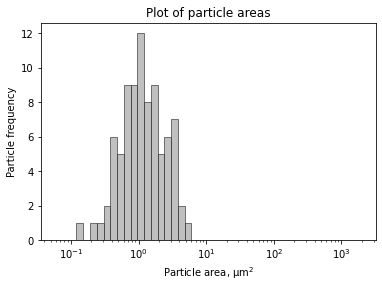

In [13]:
#Plots a histogram of the binned particle areas
plt.hist(bins[:-1], bins, weights=counts, color='silver', \
         density = False, edgecolor='black',
              linewidth=0.5) 
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
plt.ylabel("Particle frequency")
#plt.xlim([1, 10**2])
plt.title("Plot of particle areas")

The geometric mean is 1.02


Text(0.85, 0.85, 'n = 84 \n Mean = 1.0 $\\mathregular{\\mu}$m')

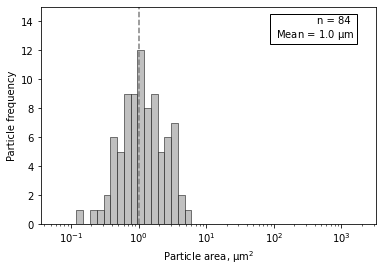

In [14]:
#Finds the geometric mean of the data
a = sum(counts*np.log10(bins[:-1]))/sum(counts)
mean = 10**a
print("The geometric mean is", round(mean,2))

#Plots same histogram now with the value for the geometric mean added
ax = plt.figure()
#Plots a histogram of the binned particle areas
plt.hist(bins[:-1], bins, weights=counts, color='silver', \
         density = False, edgecolor='black', linewidth=0.5) 
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
plt.ylabel("Particle frequency")

mean_y=[0.0, 15]
plt.plot([mean, mean],mean_y, color='grey', linestyle='dashed')
plt.ylim([0,15])
microns = "$\mathregular{\mu}$"
ax.text(.85, .85, f"n = {particles_remaining} \n \
Mean = {round(mean,1)} {microns}m", horizontalalignment="right", \
        verticalalignment="top", bbox=dict(boxstyle = "square",
                  facecolor = "white"))


In [15]:
#Outputs the filtered data as a .csv file    
filtered_data.to_csv('filtered_data.csv', index=False)   

&nbsp;  
&nbsp;  
***

# 4. Normalising data

The total area of particles in each bin is normalised by the image area measured to reduce the bias of small particles. The image area to normalised by is taken as:


Total particle area = total area of measured particles - area of large particles filtered out.


The large particles that are not sufficiently represented in the image are not considered to be part of the measured area. Particles too small to measure are assumed to still be present in the pore space between measured particles, and so are still included in this total measured area.

&nbsp;    
First, the total area of particles sorted into each bin is calculated.

In [16]:
# Creates an array to hold the sum values of each bin
total_bin_values = np.zeros(len(bins)-1) 
    
for index in range(0,len(bins)-1):
     # Takes values that are greater than or equal to the lower bin value
    bin_total = filtered_data[filtered_data["Area"] >= bins[index]] 
    
    # Takes values that are less than the upper bin value
    bin_total = bin_total[bin_total["Area"] < bins[index+1]]
    
    # Sums the equivalent diameters for that bin
    # and places into an array of sum values
    total_bin_values[index]=sum(bin_total["Area"])

In [17]:
# Checks that the total area in each bin matches that expected   
if round(sum(total_bin_values),1) == round(sum(filtered_data["Area"]),1): 
    print("The sum of each bin has been calculated successfully.")
else: print("ERROR: bin totals not calculated correctly.")

The sum of each bin has been calculated successfully.


In [18]:
# Normalises the bin totals calculated by the measured particle area
normal_bin_values = total_bin_values / total_area_not_bigs 

# Places the calculated bin totals and normalised 
# values into the dataframe bins_df
bins_df["Total bin values"] = total_bin_values 
bins_df["Normalised bin values"] = normal_bin_values

bins_df.head(5) # Displays the first 5 values of bins_df

,Bins lower,Bins upper,Counts,Total bin values,Normalised bin values
0,0.060602,0.076293,0,0.000,0.000000
1,0.076293,0.096047,0,0.000,0.000000
2,0.096047,0.120916,0,0.000,0.000000
3,0.120916,0.152225,1,0.129,0.001034
4,0.152225,0.191639,0,0.000,0.000000


In [19]:
sum(bins_df["Total bin values"])

124.75300000000001

In [20]:
sum(bins_df["Normalised bin values"])

0.9996233974358976

Text(0.5, 1.0, 'Plot of the fraction of measured particles within each bin')

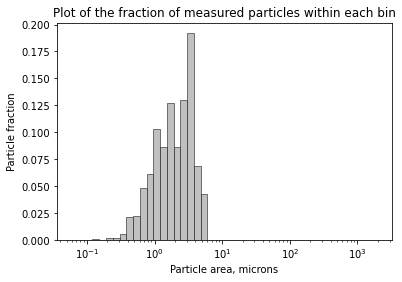

In [21]:
#Plots a histogram of the binned area data
plt.figure()
plt.hist(bins[:-1], bins, weights=normal_bin_values, \
         color='silver', density = False, \
         edgecolor='black',linewidth=0.5) 
plt.xscale('log')
plt.xlabel("Particle area, microns")
plt.ylabel("Particle fraction")
plt.title("Plot of the fraction of measured particles within each bin")

The geometric mean is 1.68


(0.0, 0.24220352564102565)

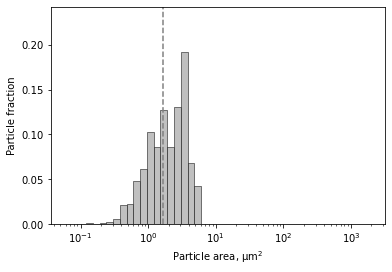

In [22]:
#Finds the geometric mean of the data
a = sum(normal_bin_values*np.log10(bins[:-1]))/sum(normal_bin_values)
mean = 10**a
print("The geometric mean is", round(mean,2))

#Plots the same histogram as above, now with the 
# value for the geometric mean added
plt.hist(bins[:-1], bins, weights=normal_bin_values, \
         color='silver', density = False, edgecolor='black',
              linewidth=0.5) #Plots the binned particle areas
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
plt.ylabel("Particle fraction")

mean_y=[0.0, 1]
plt.plot([mean, mean],mean_y, color='grey', linestyle='dashed')
plt.ylim([0,max(normal_bin_values)+0.05])

This is now the final distribution for one of the images within the image nest. This code is run in a loop to produce distributions for each image in the image nest by running Particle_analysis, which then also combines those to produce a single distribution.